<a href="https://colab.research.google.com/github/manikBS/omscs-capstone/blob/master/ydosi3_deepar_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pytorch-forecasting ta optuna statsmodels optuna-integration[pytorch_lightning]

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 197.7/197.7 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 22.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.0/819.0 kB 50.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 122.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 92.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 63.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00

In [ ]:
import os
import ta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

import torch
import pytorch_lightning as pl

from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer
from pytorch_forecasting.data import GroupNormalizer, TorchNormalizer, MultiNormalizer
from pytorch_forecasting.metrics import SMAPE
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger

# TODO: Fill in the Google Drive path where you uploaded assignment1
# Example: If you create a Fall2023 folder and put all the files under A1 folder, then 'Fall2023/A1'
GOOGLE_DRIVE_PATH_POST_MYDRIVE = 'capstone_project'
user = 'ydosi3'
if user == 'ydosi3':
  GOOGLE_DRIVE_PATH = os.path.join('/content', 'drive',
                                   'MyDrive/Colab Notebooks', GOOGLE_DRIVE_PATH_POST_MYDRIVE)
else:
  GOOGLE_DRIVE_PATH = os.path.join('/content', 'drive', 'MyDrive',
                                   GOOGLE_DRIVE_PATH_POST_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

import sys
sys.path.append(GOOGLE_DRIVE_PATH)

os.environ['GOOGLE_DRIVE_PATH'] = GOOGLE_DRIVE_PATH

os.environ['GOOGLE_DRIVE_PATH']

['ydosi3-deepar-pipeline.ipynb', 'ydosi3-tft-pipeline.ipynb', 'data', 'utils', 'src', 'data_processing.ipynb', 'model', 'models_results', 'notebooks', '__pycache__', 'MarketSimulator.py', 'E2E_Pipeline.ipynb', 'E2E_Pipeline_manik.ipynb']


'/content/drive/MyDrive/Colab Notebooks/capstone_project'

In [ ]:
from utils.commons import *

# hyperparams
TRAINING_DATA_RATIO = 0.85
VALIDATION_DATA_RATIO = 0.15
# TESTING_DATA_RATIO = 0.1

data_base = f"{os.environ['GOOGLE_DRIVE_PATH']}/data"

merged_data = get_all_data(data_base)
merged_data["stock"] = "NIFTY_IDX"
merged_data = add_indicators(merged_data)
merged_data.dropna(axis=0, how='any', inplace=True)
# add index column
merged_data["time_idx"] = merged_data.index

In [ ]:
merged_data['ema_slow_a'] = merged_data['ema_slow'].shift(10)
merged_data['ema_fast_a'] = merged_data['ema_fast'].shift(10)
merged_data['MACD_a'] = merged_data['MACD'].shift(10)
merged_data['MACD_signal_a'] = merged_data['MACD_signal'].shift(10)
merged_data['MACD_diff_a'] = merged_data['MACD_diff'].shift(10)
merged_data['stoch_a'] = merged_data['stoch'].shift(10)
merged_data['stoch_signal_a'] = merged_data['stoch_signal'].shift(10)
merged_data['vix_close_a'] = merged_data['vix_close'].shift(10)
merged_data.dropna(axis=0, how='any', inplace=True)

In [ ]:
train_df, val_df, test_df = create_train_val_test_split(
    df=merged_data, forecast_window=10, lookback_factor=5,
    forecast_start_date=pd.to_datetime('2022-04-01'),
    training_ratio=0.85,
)

/content/drive/MyDrive/Colab Notebooks/capstone_project/utils/commons.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["time_idx"] = train_df.index
/content/drive/MyDrive/Colab Notebooks/capstone_project/utils/commons.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df["time_idx"] = val_df.index
/content/drive/MyDrive/Colab Notebooks/capstone_project/utils/commons.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

In [ ]:
print("Close Column Statistics:")
print(f"Minimum: {train_df['close'].min()}")
print(f"Maximum: {train_df['close'].max()}")
print(f"Mean: {train_df['close'].mean()}")
print(f"Median: {train_df['close'].median()}")
# Calculate mode - it might have multiple modes
from scipy import stats
mode_result = stats.mode(train_df['close'])
# print(mode_result)
print(f"Mode: {mode_result.mode} (count: {mode_result.count})")


Close Column Statistics:
Minimum: 15674.25
Maximum: 18347.95
Mean: 17272.40018517566
Median: 17326.75
Mode: 15785.4 (count: 26)


In [ ]:
print("Close Column Statistics:")
print(f"Minimum: {val_df['close'].min()}")
print(f"Maximum: {val_df['close'].max()}")
print(f"Mean: {val_df['close'].mean()}")
print(f"Median: {val_df['close'].median()}")
# Calculate mode - it might have multiple modes
from scipy import stats
mode_result = stats.mode(val_df['close'])
# print(mode_result)
print(f"Mode: {mode_result.mode} (count: {mode_result.count})")

Close Column Statistics:
Minimum: 17006.9
Maximum: 17556.8
Mean: 17266.38870591664
Median: 17252.45
Mode: 17226.45 (count: 5)


In [ ]:
from torchmetrics.regression import MeanSquaredError
from pytorch_forecasting.data import TimeSeriesDataSet
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scalers = {
    'open': MinMaxScaler(),
    'high': MinMaxScaler(),
    'low': MinMaxScaler(),
    # 'close': MinMaxScaler(),
    'vix_open': MinMaxScaler(),
    'vix_high': MinMaxScaler(),
    'vix_low': MinMaxScaler(),
    # 'vix_close': MinMaxScaler(),
    'RSI': MinMaxScaler(),
    'MACD': MinMaxScaler(),
    'MACD_signal': MinMaxScaler(),
    'MACD_diff': MinMaxScaler(),
    'stoch': MinMaxScaler(),
    'stoch_signal': MinMaxScaler(),
    'ema_slow': MinMaxScaler(),
    'ema_fast': MinMaxScaler(),
    'ema_slow_a': MinMaxScaler(),
    'ema_fast_a': MinMaxScaler(),
    # 'vix_open': MinMaxScaler(),
    # 'vix_high': MinMaxScaler(),
    # 'vix_low': MinMaxScaler(),
    'vix_close_a': MinMaxScaler(),
    # 'RSI': MinMaxScaler(),
    'MACD_a': MinMaxScaler(),
    'MACD_signal_a': MinMaxScaler(),
    'MACD_diff_a': MinMaxScaler(),
    'stoch_a': MinMaxScaler(),
    'stoch_signal_a': MinMaxScaler(),
}

In [ ]:
from pytorch_forecasting.models import DeepAR
from utils.lightning_utils import ModelLightningModule
from pytorch_forecasting.metrics import *

# create dataset and dataloaders
max_encoder_length = 60
max_prediction_length = 10
training_data = TimeSeriesDataSet(
    train_df,
    time_idx="time_idx",
    # target=['close', 'vix_close'],
    target='close',
    group_ids=["stock"],
    # Fixed history and forecast lengths:
    # min_encoder_length=max_encoder_length//2,
    max_encoder_length=max_encoder_length,
    # min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    # In our setting we assume that only the time index is known
    # (you could add additional known features if available)
    # time_varying_known_reals=["time_idx"],
    # time_varying_known_reals=['vix_close_a', ],
                              # 'MACD_signal_a', 'MACD_diff_a', 'stoch_a',
                              # 'stoch_signal_a', ],
    # Historical features (OHLC and the extra indicators) are unknown in the future and help inform past behavior
    time_varying_unknown_reals=['close'],
    # time_varying_unknown_reals=['open', 'high', 'low', 'close', 'vix_open',
    #                             'vix_high', 'vix_low', 'vix_close'],
    # time_varying_known_categoricals=['gap_type', 'hour'],
    # Normalize the target by group. Softplus ensures non-negative predictions.
    # target_normalizer=GroupNormalizer(
    #     groups=["stock"], transformation="softplus"
    # ),
    target_normalizer=GroupNormalizer(
        groups=["stock"], transformation="softplus"
    ),
    # target_normalizer=MultiNormalizer(
    #     [MinMaxScaler(), MinMaxScaler()],
    # ),
    allow_missing_timesteps=True,
    # scalers=scalers,
    # add_relative_time_idx=True,
    # add_target_scales=True,
    # add_encoder_length=True,
)

# Create dataloaders for training and validation:
batch_size = calculate_batch_size(train_df.shape[0], 200)
print(f"Batch size: {batch_size}")
train_dataloader = training_data.to_dataloader(train=True, batch_size=batch_size,
                                               num_workers=0)

# Build the validation dataset from the same dataset (ensuring consistent preprocessing)
validation_data = TimeSeriesDataSet.from_dataset(
    training_data, val_df, stop_randomization=True, predict=True,
    # min_encoder_length=max_encoder_length//2,
    max_encoder_length=max_encoder_length,
    # min_prediction_length=1,
    max_prediction_length=max_prediction_length
)

valid_dataloader = validation_data.to_dataloader(batch_size=batch_size,
                                                 num_workers=0, train=False)

# configure network and trainer
pl.seed_everything(42, workers=True)
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4,
                                    patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")

l = "smape"

# initialise DeepAR model
deepar = DeepAR.from_dataset(
    training_data,
    learning_rate=0.2,
    hidden_size=16,
    rnn_layers=2,
    dropout=0.1,
    log_interval=10,
    # loss=LogNormalDistributionLoss(),
    # time_varying_reals_encoder=['close'],
    # time_varying_reals_decoder=['close']
    # cell_type="GRU"
).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

# Configure a PyTorch Lightning Trainer:
trainer = pl.Trainer(
    max_epochs=40,
    gradient_clip_val=0.01,
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
    deterministic=True
)

# Create an instance of the Lightning module, wrapping the TFT model
deepar_lightning_module = ModelLightningModule(deepar)

# fit network
trainer.fit(
    deepar_lightning_module,
    train_dataloaders=train_dataloader,
    val_dataloaders=valid_dataloader,
)


INFO:lightning_fabric.utilities.seed:Seed set to 42


Batch size: 128


/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
INFO:pytorch_lightning.utilities.rank_zero:Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_l

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=40` reached.


In [ ]:
best_model_path = trainer.checkpoint_callback.best_model_path
print(f"Best model path: {best_model_path}")

best_model = ModelLightningModule.load_from_checkpoint(best_model_path, tft=deepar)
# Now 'best_model' contains the best performing model


Best model path: lightning_logs/lightning_logs/version_0/checkpoints/epoch=39-step=6040.ckpt


In [ ]:
import os
# Save the trained model
model_save_path = f"{GOOGLE_DRIVE_PATH}/models_results/checkpoints/ydosi3-deepar-v20.ckpt"
trainer.save_checkpoint(model_save_path)
print(f"Model saved to: {model_save_path}")

Model saved to: /content/drive/MyDrive/Colab Notebooks/capstone_project/models_results/checkpoints/ydosi3-deepar-v20.ckpt


In [ ]:
# bm2 = "/content/drive/MyDrive/Colab Notebooks/capstone_project/models_results/checkpoints/ydosi3-deepar-v4.ckpt"
# best_model2 = ModelLightningModule.load_from_checkpoint(bm2, tft=deepar)

In [ ]:
min(train_losses)

5.569118976593018

In [ ]:
min(val_losses)

4.535299777984619

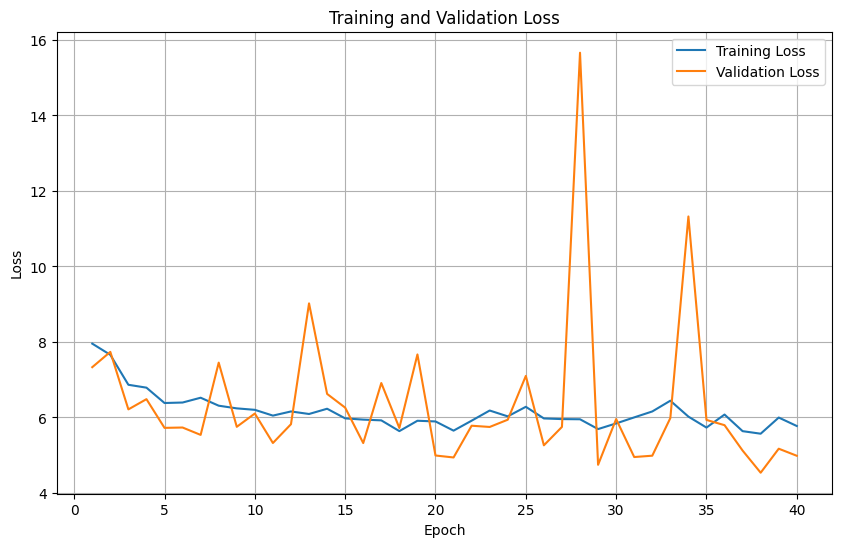

In [ ]:
train_losses = deepar_lightning_module.train_losses_per_epoch
val_losses = deepar_lightning_module.validation_losses_per_epoch

# Create epoch array
epochs = range(1, len(train_losses) + 1)

# Plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
# plt.show()
plt.savefig(f"{GOOGLE_DRIVE_PATH}/models_results/checkpoints/ydosi3-deepar-v20-loss-curve.png")

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


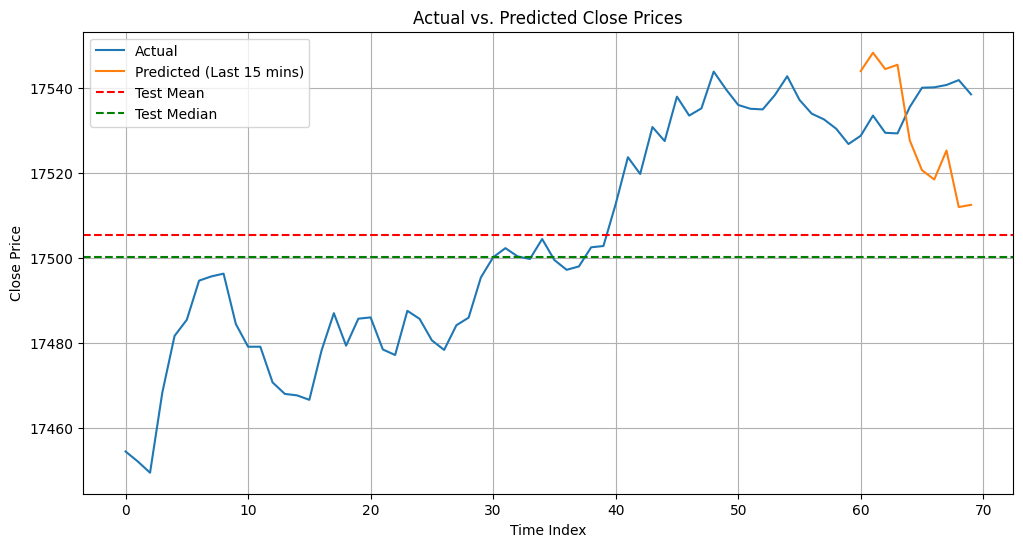

In [ ]:
start = 0
input_context = 60
test_df1 = test_df[start:start+max_prediction_length+input_context]

test_data = TimeSeriesDataSet.from_dataset(
    training_data,
    test_df1,
    predict=True,
    stop_randomization=True,
    # min_encoder_length=24,
    # max_encoder_length=24,
    # min_prediction_length=6,
    # max_prediction_length=6
)

test_dataloader = test_data.to_dataloader(batch_size=1, num_workers=0, train=False)

# Get predictions
predictions = best_model.model.predict(test_dataloader)
# predictions = deepar.predict(test_dataloader, dtype=torch.float32)
# raw_predictions = tft.predict(test_dataloader, mode="raw", return_x=True, trainer_kwargs=dict(accelerator="cpu"))

predicted_close = predictions  # Example: Assuming a single output

# Determine the indices for the last 15 minutes of predictions
prediction_indices = range(input_context, len(test_df1))
actual_indices = range(0, len(test_df1))

# Plot actual and predicted values
plt.figure(figsize=(12, 6))
plt.plot(actual_indices, test_df1['close'], label='Actual')
plt.plot(list(prediction_indices), predicted_close.tolist()[0], label='Predicted (Last 15 mins)')
# add horizontal line
plt.axhline(y=test_df1['close'].mean(), color='r', linestyle='--', label='Test Mean')
plt.axhline(y=test_df1['close'].median(), color='g', linestyle='--', label='Test Median')
# plt.axhline(y=train_df['close'].mean(), linestyle=':', label='Train Mean')
# plt.axhline(y=train_df['close'].median(), linestyle='-.', label='Train Median')
plt.xlabel("Time Index")
plt.ylabel("Close Price")
plt.title("Actual vs. Predicted Close Prices")
plt.legend()
plt.grid(True)
# plt.show()
plt.savefig(f"{GOOGLE_DRIVE_PATH}/models_results/checkpoints/ydosi3-deepar-v20-sample-pred-1500.png")


In [ ]:
def run_model_prediction(model, pred_input_df):
    test_data = TimeSeriesDataSet.from_dataset(
        training_data,
        pred_input_df,
        predict=True,
        stop_randomization=True,
        # min_encoder_length=24,
        # max_encoder_length=24,
        # min_prediction_length=6,
        # max_prediction_length=6
    )

    test_dataloader = test_data.to_dataloader(batch_size=1, num_workers=0, train=False)

    # Get predictions
    predictions = best_model.model.predict(test_dataloader)
    return predictions

def reshape_forecast_for_cnn(forecast_tensor):
    """
    Input: forecast_tensor of shape (1, T, Q) or (T, Q=3)
    Output: reshaped tensor of shape (T, 4) for CNN
    """
    if isinstance(forecast_tensor, np.ndarray):
        forecast_np = forecast_tensor
    else:
        forecast_np = forecast_tensor.detach().cpu().numpy()

    if forecast_np.ndim == 3:
        forecast_np = forecast_np.squeeze(0)  # (T, Q)

    # Add 4th channel (mean of quantiles)
    #avg_col = np.mean(forecast_np, axis=-1, keepdims=True)
    #cnn_input = np.concatenate([forecast_np, avg_col], axis=-1)  # (T, 4)
    #print(cnn_input)
    return torch.tensor(forecast_np, dtype=torch.float32)

In [ ]:
def calculate_z_score(df, column, lookback_window):
    if column not in df.columns:
        raise ValueError(f"Column '{column}' does not exist in the DataFrame.")

    # Calculate the rolling mean and standard deviation
    rolling_mean = df[column].rolling(window=lookback_window).mean()
    rolling_std = df[column].rolling(window=lookback_window).std()

    # Calculate the Z-score
    df['zscore'] = (df[column] - rolling_mean) / rolling_std
    return df


def enrich_tensor_cnn(close_tensor):
    B, window, _ = close_tensor.shape
    enriched = []

    for i in range(B):
        close = close_tensor[i, :, 0].cpu().numpy()
        df = pd.DataFrame({'close': close})

        # Calculate indicators
        df["ema"] = ta.trend.EMAIndicator(merged_data['close'], window=15).ema_indicator()
        df["rsi"] = ta.momentum.RSIIndicator(merged_data['close'], window=15).rsi()
        calculate_z_score(df, 'close', lookback_window=15)

        df.bfill(inplace=True)
        df.fillna(0, inplace=True)

        enriched.append(df[['close','ema','rsi','zscore']].values)

    enriched_tensor = torch.tensor(np.stack(enriched), dtype=torch.float32).to(close_tensor.device)
    return enriched_tensor


In [ ]:
from MarketSimulator import *
# from src.forecasting.Scalers import enrich_tensor_cnn
from utils.classify_window import classify_window

WINDOW_SIZE = 10
PATTERN_LABELS = ['head_and_shoulders', 'double_bottom', 'ascending_triangle', 'none']

def extract_windows(df, seq_len, step_size):
    windows = []
    for start in range(0, len(df) - seq_len + 1, step_size):
        end = start + seq_len
        window = df.iloc[start:end].copy()
        windows.append(window)
    return windows

num_days = 10
trading_hrs = 6.5
simulation_data_size = int(60 * trading_hrs * num_days) # minutes * hrs * days
window_seq_length = 70
step_size = WINDOW_SIZE

# Start at index 0 and then slide the window of size(WINDOW_SIZE) by step_size steps
simulation_windows = extract_windows(test_df, window_seq_length, step_size)

simulation_data = []

for fcast in simulation_windows:

    classified_forecast = dict()

    #forecast = run_model_prediction(model, scaler, fcast,feature_cols, window_seq_length)
    # fcast_tensor = torch.tensor(fcast['close'].values, dtype=torch.float32)
    # fcast_tensor = fcast_tensor.unsqueeze(0).unsqueeze(2)

    forecast = run_model_prediction(best_model.model, fcast)
    classified_forecast['window'] = fcast['close']
    classified_forecast['forecast'] = forecast.unsqueeze(2).cpu()
    classified_forecast['label'] = classify_window(
        reshape_forecast_for_cnn(enrich_tensor_cnn(forecast.unsqueeze(2))),
        model_type='1d',
        model_path=f"{GOOGLE_DRIVE_PATH}/models_results/checkpoints/CNN1D_MULTICHANNEL.pt",
        PATTERN_LABELS=PATTERN_LABELS)
    simulation_data.append(classified_forecast)


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators

In [ ]:
simulation_data[0]['window']

,close
667825,17454.40
667826,17452.05
667827,17449.40
667828,17468.25
667829,17481.60
...,...
667890,17540.00
667891,17540.10
667892,17540.65
667893,17541.80


In [ ]:
trader = Trader()

# have to use a very high price tolerance as the forecast is way off the actual close price
simulator = MarketSimulator(processed_data=simulation_data, initial_budget=100000, price_tolerance=40)

trade_log = simulator.simulate()

In [ ]:
trade_log

[(0, 'buy', np.float64(17498.091796875), np.float64(82501.908203125)),
 (0, 'sell', np.float64(17498.091796875), np.float64(100000.0)),
 (2, 'buy', np.float64(17521.44921875), np.float64(82478.55078125)),
 (2, 'sell', np.float64(17526.0), np.float64(100004.55078125)),
 (3, 'buy', np.float64(17535.900390625), np.float64(82468.650390625)),
 (3, 'sell', np.float64(17535.900390625), np.float64(100004.55078125)),
 (6, 'buy', np.float64(17535.513671875), np.float64(82469.037109375)),
 (6, 'sell', np.float64(17535.513671875), np.float64(100004.55078125)),
 (8, 'buy', np.float64(17524.9140625), np.float64(82479.63671875)),
 (8, 'sell', np.float64(17524.9140625), np.float64(100004.55078125)),
 (9, 'buy', np.float64(17529.2421875), np.float64(82475.30859375)),
 (9, 'sell', np.float64(17529.2421875), np.float64(100004.55078125)),
 (12, 'buy', np.float64(17514.837890625), np.float64(82489.712890625)),
 (12, 'sell', np.float64(17514.837890625), np.float64(100004.55078125)),
 (13, 'buy', np.float64(

In [ ]:
trade_log_df = pd.DataFrame(trade_log, columns=['idx', 'signal', 'price', 'portfolio'])
trade_log_df.head()

,idx,signal,price,portfolio
0,0,buy,17498.091797,82501.908203
1,0,sell,17498.091797,100000.000000
2,2,buy,17521.449219,82478.550781
3,2,sell,17526.000000,100004.550781
4,3,buy,17535.900391,82468.650391


In [ ]:
log_file_path = f"{GOOGLE_DRIVE_PATH}/models_results/checkpoints/ydosi3-deepar-trade-v20-1dconv.log"
trade_log_df.to_csv(log_file_path, index=False)  # Save to CSV, without the index
print(f"Trade log saved to: {log_file_path}")


Trade log saved to: /content/drive/MyDrive/Colab Notebooks/capstone_project/models_results/checkpoints/ydosi3-deepar-trade-v20-1dconv.log
